In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    eloss += -tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # maximize loss
    aloss2_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    aloss2 = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    #rewards__ = tf.square(e_next_states_logits - next_states) 
    next_states_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                               labels=next_states_labels)
    rewards_in = tf.reduce_mean(tf.reduce_sum(next_states_loss, axis=1))
    targetQs = rewards_in + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2, rewards_in

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2, self.rewards_in = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            rewards_in = sess.run(model.rewards_in, feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            #print('rewards_in.mean():', rewards_in.mean())
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 aloss:0.7498 eloss:8.8909 aloss2:3.3772 exploreP:0.9985
Episode:1 meanR:16.5000 R:18.0000 rate:0.0360 aloss:0.7453 eloss:8.8283 aloss2:3.3707 exploreP:0.9967
Episode:2 meanR:15.6667 R:14.0000 rate:0.0280 aloss:0.7481 eloss:8.8559 aloss2:3.3868 exploreP:0.9954
Episode:3 meanR:14.7500 R:12.0000 rate:0.0240 aloss:0.7512 eloss:8.8011 aloss2:3.3838 exploreP:0.9942
Episode:4 meanR:19.2000 R:37.0000 rate:0.0740 aloss:0.7438 eloss:8.8127 aloss2:3.3998 exploreP:0.9905
Episode:5 meanR:22.0000 R:36.0000 rate:0.0720 aloss:0.7454 eloss:8.7559 aloss2:3.3966 exploreP:0.9870
Episode:6 meanR:20.7143 R:13.0000 rate:0.0260 aloss:0.7468 eloss:8.7391 aloss2:3.4137 exploreP:0.9857
Episode:7 meanR:19.8750 R:14.0000 rate:0.0280 aloss:0.7491 eloss:8.7606 aloss2:3.4313 exploreP:0.9844
Episode:8 meanR:22.1111 R:40.0000 rate:0.0800 aloss:0.7404 eloss:8.6890 aloss2:3.4224 exploreP:0.9805
Episode:9 meanR:21.6000 R:17.0000 rate:0.0340 aloss:0.7413 eloss:8.6095 aloss2:3.4

Episode:80 meanR:25.8272 R:15.0000 rate:0.0300 aloss:0.7006 eloss:7.7311 aloss2:4.4182 exploreP:0.8131
Episode:81 meanR:25.7561 R:20.0000 rate:0.0400 aloss:0.7119 eloss:7.8362 aloss2:4.4050 exploreP:0.8115
Episode:82 meanR:26.2530 R:67.0000 rate:0.1340 aloss:0.6986 eloss:7.7434 aloss2:4.4885 exploreP:0.8062
Episode:83 meanR:26.3333 R:33.0000 rate:0.0660 aloss:0.7023 eloss:7.8336 aloss2:4.4730 exploreP:0.8035
Episode:84 meanR:26.3176 R:25.0000 rate:0.0500 aloss:0.7054 eloss:7.8564 aloss2:4.5160 exploreP:0.8016
Episode:85 meanR:26.7791 R:66.0000 rate:0.1320 aloss:0.7363 eloss:7.8999 aloss2:4.5573 exploreP:0.7964
Episode:86 meanR:26.6207 R:13.0000 rate:0.0260 aloss:0.7104 eloss:7.7729 aloss2:4.6159 exploreP:0.7953
Episode:87 meanR:26.6023 R:25.0000 rate:0.0500 aloss:0.7468 eloss:7.8197 aloss2:4.6451 exploreP:0.7934
Episode:88 meanR:26.6517 R:31.0000 rate:0.0620 aloss:0.7216 eloss:7.8202 aloss2:4.6635 exploreP:0.7909
Episode:89 meanR:26.5444 R:17.0000 rate:0.0340 aloss:0.7188 eloss:7.7908 

Episode:159 meanR:37.6600 R:31.0000 rate:0.0620 aloss:0.8545 eloss:6.8462 aloss2:7.2510 exploreP:0.5980
Episode:160 meanR:37.7600 R:50.0000 rate:0.1000 aloss:0.8562 eloss:6.9656 aloss2:7.0915 exploreP:0.5951
Episode:161 meanR:38.0000 R:40.0000 rate:0.0800 aloss:0.8622 eloss:6.8510 aloss2:7.1576 exploreP:0.5927
Episode:162 meanR:38.0900 R:36.0000 rate:0.0720 aloss:0.8180 eloss:6.7431 aloss2:7.2650 exploreP:0.5906
Episode:163 meanR:38.2400 R:48.0000 rate:0.0960 aloss:0.8499 eloss:6.7152 aloss2:7.3377 exploreP:0.5878
Episode:164 meanR:38.2600 R:27.0000 rate:0.0540 aloss:0.8281 eloss:6.7405 aloss2:7.3415 exploreP:0.5863
Episode:165 meanR:38.4600 R:59.0000 rate:0.1180 aloss:0.8939 eloss:6.6435 aloss2:7.4059 exploreP:0.5829
Episode:166 meanR:38.8300 R:52.0000 rate:0.1040 aloss:0.8383 eloss:6.6666 aloss2:7.4190 exploreP:0.5799
Episode:167 meanR:38.9200 R:42.0000 rate:0.0840 aloss:0.8295 eloss:6.6314 aloss2:7.4030 exploreP:0.5775
Episode:168 meanR:39.2900 R:57.0000 rate:0.1140 aloss:0.9294 elo

Episode:238 meanR:39.7900 R:9.0000 rate:0.0180 aloss:0.7888 eloss:6.4537 aloss2:8.8020 exploreP:0.4370
Episode:239 meanR:40.6200 R:108.0000 rate:0.2160 aloss:0.8258 eloss:5.6307 aloss2:9.2084 exploreP:0.4324
Episode:240 meanR:40.3100 R:10.0000 rate:0.0200 aloss:0.8019 eloss:5.4737 aloss2:9.2372 exploreP:0.4320
Episode:241 meanR:39.8100 R:10.0000 rate:0.0200 aloss:0.8093 eloss:4.9936 aloss2:9.6347 exploreP:0.4316
Episode:242 meanR:39.5600 R:10.0000 rate:0.0200 aloss:0.7665 eloss:5.4356 aloss2:9.5130 exploreP:0.4312
Episode:243 meanR:39.1500 R:16.0000 rate:0.0320 aloss:0.8848 eloss:4.9619 aloss2:9.6904 exploreP:0.4305
Episode:244 meanR:38.9800 R:20.0000 rate:0.0400 aloss:0.7910 eloss:4.9712 aloss2:9.2643 exploreP:0.4296
Episode:245 meanR:38.6300 R:12.0000 rate:0.0240 aloss:0.8191 eloss:4.8361 aloss2:9.5983 exploreP:0.4291
Episode:246 meanR:38.3500 R:10.0000 rate:0.0200 aloss:0.7644 eloss:5.0537 aloss2:9.5347 exploreP:0.4287
Episode:247 meanR:38.3300 R:14.0000 rate:0.0280 aloss:0.7532 elo

Episode:317 meanR:29.2600 R:34.0000 rate:0.0680 aloss:0.6984 eloss:5.6540 aloss2:10.0649 exploreP:0.3563
Episode:318 meanR:29.1100 R:20.0000 rate:0.0400 aloss:0.6905 eloss:5.6402 aloss2:10.0805 exploreP:0.3556
Episode:319 meanR:28.9800 R:26.0000 rate:0.0520 aloss:0.6722 eloss:5.6671 aloss2:10.1153 exploreP:0.3547
Episode:320 meanR:28.9200 R:20.0000 rate:0.0400 aloss:0.7005 eloss:5.8978 aloss2:9.9664 exploreP:0.3541
Episode:321 meanR:28.9000 R:21.0000 rate:0.0420 aloss:0.7146 eloss:5.7335 aloss2:10.3183 exploreP:0.3533
Episode:322 meanR:29.0600 R:44.0000 rate:0.0880 aloss:0.7004 eloss:5.9510 aloss2:9.9526 exploreP:0.3518
Episode:323 meanR:29.2800 R:37.0000 rate:0.0740 aloss:0.6945 eloss:6.0662 aloss2:9.9636 exploreP:0.3506
Episode:324 meanR:29.2300 R:25.0000 rate:0.0500 aloss:0.6954 eloss:6.4003 aloss2:10.1404 exploreP:0.3497
Episode:325 meanR:29.4400 R:56.0000 rate:0.1120 aloss:0.6997 eloss:5.9714 aloss2:10.1217 exploreP:0.3478
Episode:326 meanR:29.2900 R:12.0000 rate:0.0240 aloss:0.70

Episode:396 meanR:27.3900 R:19.0000 rate:0.0380 aloss:0.6782 eloss:4.9102 aloss2:12.0810 exploreP:0.2898
Episode:397 meanR:27.2800 R:10.0000 rate:0.0200 aloss:0.7151 eloss:5.0349 aloss2:12.4374 exploreP:0.2895
Episode:398 meanR:26.9200 R:13.0000 rate:0.0260 aloss:0.7070 eloss:5.2209 aloss2:12.1185 exploreP:0.2892
Episode:399 meanR:26.9000 R:23.0000 rate:0.0460 aloss:0.7031 eloss:5.0765 aloss2:12.1661 exploreP:0.2885
Episode:400 meanR:26.7500 R:13.0000 rate:0.0260 aloss:0.6707 eloss:8.6785 aloss2:12.2719 exploreP:0.2882
Episode:401 meanR:26.5700 R:19.0000 rate:0.0380 aloss:0.6916 eloss:6.2688 aloss2:11.6128 exploreP:0.2876
Episode:402 meanR:26.4700 R:13.0000 rate:0.0260 aloss:0.7260 eloss:5.1553 aloss2:12.3713 exploreP:0.2873
Episode:403 meanR:26.3100 R:16.0000 rate:0.0320 aloss:0.7152 eloss:5.0611 aloss2:12.3713 exploreP:0.2868
Episode:404 meanR:26.1000 R:14.0000 rate:0.0280 aloss:0.7154 eloss:5.0053 aloss2:12.6094 exploreP:0.2864
Episode:405 meanR:25.9400 R:18.0000 rate:0.0360 aloss:0

Episode:475 meanR:19.6600 R:16.0000 rate:0.0320 aloss:0.7200 eloss:4.4255 aloss2:13.7931 exploreP:0.2514
Episode:476 meanR:19.6500 R:10.0000 rate:0.0200 aloss:0.7378 eloss:4.5209 aloss2:14.0408 exploreP:0.2511
Episode:477 meanR:19.4300 R:11.0000 rate:0.0220 aloss:0.7185 eloss:4.4842 aloss2:13.8333 exploreP:0.2509
Episode:478 meanR:19.2700 R:12.0000 rate:0.0240 aloss:0.7097 eloss:4.3765 aloss2:13.6761 exploreP:0.2506
Episode:479 meanR:19.1300 R:10.0000 rate:0.0200 aloss:0.7108 eloss:4.2261 aloss2:13.8733 exploreP:0.2503
Episode:480 meanR:18.9800 R:14.0000 rate:0.0280 aloss:0.7200 eloss:4.4062 aloss2:13.8555 exploreP:0.2500
Episode:481 meanR:18.7900 R:9.0000 rate:0.0180 aloss:0.7172 eloss:4.4228 aloss2:13.9027 exploreP:0.2498
Episode:482 meanR:18.5900 R:11.0000 rate:0.0220 aloss:0.6905 eloss:4.7042 aloss2:13.7402 exploreP:0.2495
Episode:483 meanR:18.4600 R:12.0000 rate:0.0240 aloss:0.7281 eloss:4.4672 aloss2:14.1494 exploreP:0.2492
Episode:484 meanR:18.3000 R:10.0000 rate:0.0200 aloss:0.

Episode:554 meanR:16.1900 R:17.0000 rate:0.0340 aloss:0.7067 eloss:3.8486 aloss2:15.5714 exploreP:0.2228
Episode:555 meanR:16.0900 R:9.0000 rate:0.0180 aloss:0.7371 eloss:3.9565 aloss2:15.8319 exploreP:0.2226
Episode:556 meanR:16.0900 R:10.0000 rate:0.0200 aloss:0.7385 eloss:4.1060 aloss2:15.5956 exploreP:0.2224
Episode:557 meanR:16.0200 R:13.0000 rate:0.0260 aloss:0.6929 eloss:4.3642 aloss2:15.1619 exploreP:0.2222
Episode:558 meanR:16.1100 R:28.0000 rate:0.0560 aloss:0.7035 eloss:3.7381 aloss2:15.6932 exploreP:0.2216
Episode:559 meanR:16.1000 R:30.0000 rate:0.0600 aloss:0.6944 eloss:3.8204 aloss2:15.6704 exploreP:0.2209
Episode:560 meanR:16.1400 R:22.0000 rate:0.0440 aloss:0.7231 eloss:4.2278 aloss2:15.9645 exploreP:0.2205
Episode:561 meanR:16.0900 R:11.0000 rate:0.0220 aloss:0.7072 eloss:3.8609 aloss2:16.2004 exploreP:0.2202
Episode:562 meanR:16.0800 R:15.0000 rate:0.0300 aloss:0.7039 eloss:3.8775 aloss2:15.7894 exploreP:0.2199
Episode:563 meanR:16.0800 R:10.0000 rate:0.0200 aloss:0.

Episode:633 meanR:16.0500 R:9.0000 rate:0.0180 aloss:0.7033 eloss:3.1483 aloss2:17.1231 exploreP:0.1980
Episode:634 meanR:16.2000 R:26.0000 rate:0.0520 aloss:0.6984 eloss:3.1307 aloss2:17.0878 exploreP:0.1976
Episode:635 meanR:16.1100 R:21.0000 rate:0.0420 aloss:0.7025 eloss:3.1381 aloss2:17.4608 exploreP:0.1972
Episode:636 meanR:16.1800 R:18.0000 rate:0.0360 aloss:0.7050 eloss:3.0702 aloss2:17.4156 exploreP:0.1968
Episode:637 meanR:16.2500 R:20.0000 rate:0.0400 aloss:0.6703 eloss:4.1797 aloss2:17.0440 exploreP:0.1965
Episode:638 meanR:16.1300 R:10.0000 rate:0.0200 aloss:0.7169 eloss:3.1119 aloss2:17.7386 exploreP:0.1963
Episode:639 meanR:16.2700 R:28.0000 rate:0.0560 aloss:0.7210 eloss:3.3959 aloss2:17.3065 exploreP:0.1958
Episode:640 meanR:16.3200 R:16.0000 rate:0.0320 aloss:0.7007 eloss:3.1731 aloss2:17.5175 exploreP:0.1955
Episode:641 meanR:15.9400 R:17.0000 rate:0.0340 aloss:0.7261 eloss:2.9876 aloss2:17.4362 exploreP:0.1951
Episode:642 meanR:16.0200 R:18.0000 rate:0.0360 aloss:0.

Episode:712 meanR:15.4700 R:17.0000 rate:0.0340 aloss:0.7106 eloss:2.6268 aloss2:19.1238 exploreP:0.1763
Episode:713 meanR:15.6300 R:26.0000 rate:0.0520 aloss:0.7043 eloss:3.0161 aloss2:19.0981 exploreP:0.1759
Episode:714 meanR:15.8600 R:34.0000 rate:0.0680 aloss:0.7426 eloss:3.1491 aloss2:19.2551 exploreP:0.1753
Episode:715 meanR:15.9900 R:23.0000 rate:0.0460 aloss:0.7218 eloss:2.8775 aloss2:19.2385 exploreP:0.1750
Episode:716 meanR:16.0800 R:21.0000 rate:0.0420 aloss:0.7131 eloss:2.6505 aloss2:19.1459 exploreP:0.1746
Episode:717 meanR:16.2000 R:23.0000 rate:0.0460 aloss:0.7265 eloss:3.6429 aloss2:18.7492 exploreP:0.1742
Episode:718 meanR:16.2300 R:18.0000 rate:0.0360 aloss:0.7155 eloss:2.9662 aloss2:19.0961 exploreP:0.1739
Episode:719 meanR:16.2600 R:12.0000 rate:0.0240 aloss:0.7187 eloss:3.0453 aloss2:19.0594 exploreP:0.1737
Episode:720 meanR:16.4800 R:37.0000 rate:0.0740 aloss:0.7220 eloss:2.7582 aloss2:19.2135 exploreP:0.1731
Episode:721 meanR:16.5500 R:17.0000 rate:0.0340 aloss:0

Episode:790 meanR:77.9500 R:31.0000 rate:0.0620 aloss:0.8190 eloss:1.7733 aloss2:28.0691 exploreP:0.0895
Episode:791 meanR:77.8400 R:11.0000 rate:0.0220 aloss:0.8085 eloss:0.6592 aloss2:29.1880 exploreP:0.0894
Episode:792 meanR:77.5700 R:31.0000 rate:0.0620 aloss:0.8284 eloss:1.6585 aloss2:28.0478 exploreP:0.0892
Episode:793 meanR:77.5400 R:10.0000 rate:0.0200 aloss:0.8110 eloss:2.4048 aloss2:27.9724 exploreP:0.0891
Episode:794 meanR:77.5800 R:14.0000 rate:0.0280 aloss:0.8772 eloss:3.6908 aloss2:27.2402 exploreP:0.0890
Episode:795 meanR:77.5900 R:11.0000 rate:0.0220 aloss:0.8497 eloss:1.0640 aloss2:28.3351 exploreP:0.0889
Episode:796 meanR:77.6300 R:24.0000 rate:0.0480 aloss:0.8355 eloss:1.2717 aloss2:27.9113 exploreP:0.0887
Episode:797 meanR:77.5700 R:12.0000 rate:0.0240 aloss:0.7519 eloss:1.9745 aloss2:28.6935 exploreP:0.0886
Episode:798 meanR:77.5900 R:22.0000 rate:0.0440 aloss:0.8007 eloss:1.4836 aloss2:28.0363 exploreP:0.0884
Episode:799 meanR:77.5100 R:13.0000 rate:0.0260 aloss:0

Episode:869 meanR:20.0300 R:33.0000 rate:0.0660 aloss:0.8814 eloss:1.7598 aloss2:31.3533 exploreP:0.0779
Episode:870 meanR:20.1000 R:16.0000 rate:0.0320 aloss:0.9659 eloss:2.6934 aloss2:29.5612 exploreP:0.0778
Episode:871 meanR:20.1000 R:10.0000 rate:0.0200 aloss:0.7416 eloss:1.1486 aloss2:31.7350 exploreP:0.0777
Episode:872 meanR:20.1000 R:10.0000 rate:0.0200 aloss:1.0146 eloss:11.9582 aloss2:30.8137 exploreP:0.0776
Episode:873 meanR:20.1000 R:10.0000 rate:0.0200 aloss:0.7871 eloss:2.0557 aloss2:30.6171 exploreP:0.0776
Episode:874 meanR:20.0800 R:11.0000 rate:0.0220 aloss:0.7559 eloss:1.3334 aloss2:30.8534 exploreP:0.0775
Episode:875 meanR:20.0700 R:17.0000 rate:0.0340 aloss:0.7981 eloss:0.6780 aloss2:31.1559 exploreP:0.0774
Episode:876 meanR:20.0800 R:16.0000 rate:0.0320 aloss:0.8347 eloss:1.1285 aloss2:30.9513 exploreP:0.0773
Episode:877 meanR:20.0700 R:10.0000 rate:0.0200 aloss:0.8086 eloss:1.0143 aloss2:30.0062 exploreP:0.0772
Episode:878 meanR:19.8200 R:20.0000 rate:0.0400 aloss:

Episode:948 meanR:17.6500 R:10.0000 rate:0.0200 aloss:0.8016 eloss:1.0524 aloss2:32.8397 exploreP:0.0692
Episode:949 meanR:18.2200 R:67.0000 rate:0.1340 aloss:0.8205 eloss:0.6054 aloss2:32.2839 exploreP:0.0688
Episode:950 meanR:18.1500 R:11.0000 rate:0.0220 aloss:0.9606 eloss:4.9915 aloss2:32.9412 exploreP:0.0688
Episode:951 meanR:17.9600 R:17.0000 rate:0.0340 aloss:0.8190 eloss:1.1329 aloss2:31.3973 exploreP:0.0687
Episode:952 meanR:17.9600 R:18.0000 rate:0.0360 aloss:0.8660 eloss:1.3687 aloss2:32.2145 exploreP:0.0686
Episode:953 meanR:17.8700 R:15.0000 rate:0.0300 aloss:0.7775 eloss:0.3224 aloss2:31.9529 exploreP:0.0685
Episode:954 meanR:17.7800 R:10.0000 rate:0.0200 aloss:0.7100 eloss:1.3319 aloss2:32.1900 exploreP:0.0684
Episode:955 meanR:17.7000 R:10.0000 rate:0.0200 aloss:0.7638 eloss:0.2622 aloss2:33.1998 exploreP:0.0684
Episode:956 meanR:17.6400 R:10.0000 rate:0.0200 aloss:0.7049 eloss:0.5105 aloss2:32.6907 exploreP:0.0683
Episode:957 meanR:17.7000 R:24.0000 rate:0.0480 aloss:0

Episode:1026 meanR:18.5100 R:16.0000 rate:0.0320 aloss:0.8839 eloss:2.5771 aloss2:33.2799 exploreP:0.0610
Episode:1027 meanR:18.4000 R:14.0000 rate:0.0280 aloss:0.7662 eloss:0.3706 aloss2:34.4496 exploreP:0.0609
Episode:1028 meanR:18.5200 R:22.0000 rate:0.0440 aloss:0.7090 eloss:7.2816 aloss2:33.0356 exploreP:0.0608
Episode:1029 meanR:18.5800 R:18.0000 rate:0.0360 aloss:0.7941 eloss:1.3304 aloss2:34.3267 exploreP:0.0607
Episode:1030 meanR:18.5200 R:10.0000 rate:0.0200 aloss:0.6952 eloss:0.2396 aloss2:34.1436 exploreP:0.0607
Episode:1031 meanR:18.6500 R:23.0000 rate:0.0460 aloss:0.8354 eloss:2.4635 aloss2:33.1754 exploreP:0.0606
Episode:1032 meanR:18.5200 R:12.0000 rate:0.0240 aloss:0.8110 eloss:4.8987 aloss2:33.6093 exploreP:0.0605
Episode:1033 meanR:18.5200 R:10.0000 rate:0.0200 aloss:0.8642 eloss:1.4497 aloss2:34.6212 exploreP:0.0605
Episode:1034 meanR:18.4100 R:10.0000 rate:0.0200 aloss:0.8486 eloss:0.6274 aloss2:34.4209 exploreP:0.0604
Episode:1035 meanR:18.2700 R:20.0000 rate:0.04

Episode:1104 meanR:17.8200 R:10.0000 rate:0.0200 aloss:0.7573 eloss:-0.3096 aloss2:35.1016 exploreP:0.0545
Episode:1105 meanR:18.2900 R:62.0000 rate:0.1240 aloss:0.7999 eloss:1.2147 aloss2:35.5051 exploreP:0.0542
Episode:1106 meanR:18.2900 R:10.0000 rate:0.0200 aloss:0.6627 eloss:9.4660 aloss2:33.7725 exploreP:0.0542
Episode:1107 meanR:18.2700 R:9.0000 rate:0.0180 aloss:0.7340 eloss:0.5363 aloss2:35.0329 exploreP:0.0541
Episode:1108 meanR:18.1500 R:10.0000 rate:0.0200 aloss:0.7318 eloss:-0.4170 aloss2:34.9903 exploreP:0.0541
Episode:1109 meanR:18.1500 R:10.0000 rate:0.0200 aloss:0.7816 eloss:1.7046 aloss2:34.9691 exploreP:0.0540
Episode:1110 meanR:18.1400 R:11.0000 rate:0.0220 aloss:0.7520 eloss:0.8032 aloss2:34.6969 exploreP:0.0540
Episode:1111 meanR:18.1700 R:13.0000 rate:0.0260 aloss:0.8219 eloss:-0.1685 aloss2:35.8891 exploreP:0.0539
Episode:1112 meanR:17.9000 R:9.0000 rate:0.0180 aloss:0.7390 eloss:0.0348 aloss2:35.0437 exploreP:0.0539
Episode:1113 meanR:17.7800 R:9.0000 rate:0.01

Episode:1182 meanR:17.8800 R:22.0000 rate:0.0440 aloss:0.7302 eloss:-0.2578 aloss2:35.7687 exploreP:0.0485
Episode:1183 meanR:17.8100 R:11.0000 rate:0.0220 aloss:0.7300 eloss:2.7522 aloss2:37.2688 exploreP:0.0485
Episode:1184 meanR:17.7700 R:22.0000 rate:0.0440 aloss:0.7308 eloss:-0.8438 aloss2:35.9419 exploreP:0.0484
Episode:1185 meanR:17.6800 R:20.0000 rate:0.0400 aloss:0.7218 eloss:2.9825 aloss2:34.9194 exploreP:0.0483
Episode:1186 meanR:17.7800 R:22.0000 rate:0.0440 aloss:0.7631 eloss:3.8600 aloss2:35.9211 exploreP:0.0482
Episode:1187 meanR:17.6200 R:10.0000 rate:0.0200 aloss:0.7177 eloss:1.0214 aloss2:35.8699 exploreP:0.0482
Episode:1188 meanR:17.4500 R:12.0000 rate:0.0240 aloss:0.7440 eloss:1.6189 aloss2:35.2079 exploreP:0.0481
Episode:1189 meanR:17.3500 R:12.0000 rate:0.0240 aloss:0.8363 eloss:2.7333 aloss2:35.4814 exploreP:0.0481
Episode:1190 meanR:17.2600 R:11.0000 rate:0.0220 aloss:0.7394 eloss:0.3191 aloss2:36.0269 exploreP:0.0481
Episode:1191 meanR:17.4800 R:37.0000 rate:0.

Episode:1260 meanR:17.8400 R:10.0000 rate:0.0200 aloss:0.6896 eloss:0.1051 aloss2:37.5321 exploreP:0.0437
Episode:1261 meanR:17.8100 R:9.0000 rate:0.0180 aloss:0.8156 eloss:-0.2488 aloss2:37.7312 exploreP:0.0436
Episode:1262 meanR:18.2500 R:56.0000 rate:0.1120 aloss:0.7407 eloss:-0.3468 aloss2:37.2078 exploreP:0.0434
Episode:1263 meanR:18.1100 R:10.0000 rate:0.0200 aloss:0.7522 eloss:-0.0757 aloss2:38.3056 exploreP:0.0434
Episode:1264 meanR:17.6600 R:11.0000 rate:0.0220 aloss:0.7870 eloss:-0.1308 aloss2:37.5111 exploreP:0.0434
Episode:1265 meanR:17.5400 R:9.0000 rate:0.0180 aloss:0.7264 eloss:-1.0008 aloss2:37.4059 exploreP:0.0433
Episode:1266 meanR:17.5400 R:9.0000 rate:0.0180 aloss:0.6918 eloss:0.2451 aloss2:38.1216 exploreP:0.0433
Episode:1267 meanR:17.6800 R:24.0000 rate:0.0480 aloss:0.7412 eloss:0.4202 aloss2:37.7871 exploreP:0.0432
Episode:1268 meanR:17.7000 R:12.0000 rate:0.0240 aloss:0.7101 eloss:-0.1917 aloss2:37.1393 exploreP:0.0432
Episode:1269 meanR:19.0200 R:157.0000 rate:

Episode:1337 meanR:21.7800 R:18.0000 rate:0.0360 aloss:0.7707 eloss:0.0846 aloss2:38.6062 exploreP:0.0380
Episode:1338 meanR:21.7500 R:11.0000 rate:0.0220 aloss:0.7232 eloss:0.4905 aloss2:36.9915 exploreP:0.0379
Episode:1339 meanR:21.6500 R:11.0000 rate:0.0220 aloss:0.7414 eloss:-0.6756 aloss2:39.2121 exploreP:0.0379
Episode:1340 meanR:21.9300 R:38.0000 rate:0.0760 aloss:0.7473 eloss:-0.8304 aloss2:38.7383 exploreP:0.0378
Episode:1341 meanR:22.1500 R:32.0000 rate:0.0640 aloss:0.7302 eloss:-1.2391 aloss2:38.8474 exploreP:0.0377
Episode:1342 meanR:22.2400 R:19.0000 rate:0.0380 aloss:0.7665 eloss:-0.8747 aloss2:38.1820 exploreP:0.0376
Episode:1343 meanR:22.4700 R:33.0000 rate:0.0660 aloss:0.7415 eloss:0.1088 aloss2:38.1445 exploreP:0.0376
Episode:1344 meanR:22.4700 R:10.0000 rate:0.0200 aloss:0.7824 eloss:0.3673 aloss2:39.6800 exploreP:0.0375
Episode:1345 meanR:22.4700 R:10.0000 rate:0.0200 aloss:0.6873 eloss:-1.2155 aloss2:38.4322 exploreP:0.0375
Episode:1346 meanR:22.6100 R:23.0000 rate

Episode:1414 meanR:25.4700 R:25.0000 rate:0.0500 aloss:0.7612 eloss:0.4341 aloss2:41.3840 exploreP:0.0325
Episode:1415 meanR:25.8400 R:55.0000 rate:0.1100 aloss:0.7533 eloss:-0.4645 aloss2:40.4654 exploreP:0.0323
Episode:1416 meanR:25.8400 R:11.0000 rate:0.0220 aloss:0.7663 eloss:-0.7743 aloss2:40.7334 exploreP:0.0323
Episode:1417 meanR:25.8000 R:11.0000 rate:0.0220 aloss:0.7436 eloss:-0.6364 aloss2:40.6223 exploreP:0.0323
Episode:1418 meanR:26.0700 R:37.0000 rate:0.0740 aloss:0.7363 eloss:2.0753 aloss2:40.4179 exploreP:0.0322
Episode:1419 meanR:27.1000 R:120.0000 rate:0.2400 aloss:0.7187 eloss:1.2408 aloss2:40.3657 exploreP:0.0319
Episode:1420 meanR:27.1300 R:13.0000 rate:0.0260 aloss:0.6997 eloss:0.3521 aloss2:41.0224 exploreP:0.0319
Episode:1421 meanR:27.8100 R:87.0000 rate:0.1740 aloss:0.7237 eloss:0.3085 aloss2:40.4029 exploreP:0.0317
Episode:1422 meanR:27.9100 R:20.0000 rate:0.0400 aloss:0.7070 eloss:-1.7706 aloss2:40.2179 exploreP:0.0317
Episode:1423 meanR:28.8400 R:103.0000 rat

Episode:1491 meanR:41.2000 R:37.0000 rate:0.0740 aloss:0.7090 eloss:-0.7355 aloss2:42.1287 exploreP:0.0257
Episode:1492 meanR:41.8600 R:107.0000 rate:0.2140 aloss:0.7134 eloss:0.1613 aloss2:42.2709 exploreP:0.0255
Episode:1493 meanR:41.9700 R:36.0000 rate:0.0720 aloss:0.7200 eloss:5.8492 aloss2:41.7584 exploreP:0.0255
Episode:1494 meanR:41.6400 R:42.0000 rate:0.0840 aloss:0.7090 eloss:-1.2988 aloss2:42.1935 exploreP:0.0254
Episode:1495 meanR:41.8400 R:30.0000 rate:0.0600 aloss:0.7280 eloss:-0.8690 aloss2:41.8801 exploreP:0.0254
Episode:1496 meanR:41.8800 R:25.0000 rate:0.0500 aloss:0.6873 eloss:9.0653 aloss2:40.5384 exploreP:0.0253
Episode:1497 meanR:42.1900 R:55.0000 rate:0.1100 aloss:0.7156 eloss:-0.7317 aloss2:41.6060 exploreP:0.0252
Episode:1498 meanR:42.9100 R:86.0000 rate:0.1720 aloss:0.7176 eloss:-0.1672 aloss2:41.8919 exploreP:0.0251
Episode:1499 meanR:42.5000 R:95.0000 rate:0.1900 aloss:0.7525 eloss:0.1661 aloss2:42.1698 exploreP:0.0250
Episode:1500 meanR:42.9800 R:58.0000 rat

Episode:1568 meanR:53.5100 R:93.0000 rate:0.1860 aloss:0.6881 eloss:-0.7908 aloss2:43.1505 exploreP:0.0205
Episode:1569 meanR:53.0800 R:27.0000 rate:0.0540 aloss:0.7142 eloss:-0.8618 aloss2:43.3705 exploreP:0.0205
Episode:1570 meanR:53.1400 R:77.0000 rate:0.1540 aloss:0.6952 eloss:2.6335 aloss2:43.1980 exploreP:0.0204
Episode:1571 meanR:53.7200 R:89.0000 rate:0.1780 aloss:0.7420 eloss:-0.0721 aloss2:43.2750 exploreP:0.0203
Episode:1572 meanR:53.6000 R:95.0000 rate:0.1900 aloss:0.6998 eloss:0.2557 aloss2:43.0340 exploreP:0.0202
Episode:1573 meanR:53.2300 R:10.0000 rate:0.0200 aloss:0.7169 eloss:-0.8905 aloss2:41.6921 exploreP:0.0202
Episode:1574 meanR:53.6100 R:89.0000 rate:0.1780 aloss:0.7095 eloss:-0.8452 aloss2:43.0242 exploreP:0.0201
Episode:1575 meanR:53.7600 R:25.0000 rate:0.0500 aloss:0.7374 eloss:-0.7443 aloss2:43.2816 exploreP:0.0201
Episode:1576 meanR:53.7100 R:10.0000 rate:0.0200 aloss:0.7171 eloss:-1.5052 aloss2:43.5263 exploreP:0.0201
Episode:1577 meanR:54.0000 R:39.0000 ra

Episode:1645 meanR:60.2900 R:59.0000 rate:0.1180 aloss:0.7116 eloss:0.8717 aloss2:44.5805 exploreP:0.0163
Episode:1646 meanR:61.5800 R:189.0000 rate:0.3780 aloss:0.6970 eloss:-0.3904 aloss2:44.7151 exploreP:0.0162
Episode:1647 meanR:61.5700 R:86.0000 rate:0.1720 aloss:0.7001 eloss:-1.1303 aloss2:45.1117 exploreP:0.0161
Episode:1648 meanR:61.2400 R:10.0000 rate:0.0200 aloss:0.7304 eloss:-0.9701 aloss2:43.7102 exploreP:0.0161
Episode:1649 meanR:61.4200 R:115.0000 rate:0.2300 aloss:0.7143 eloss:-1.0718 aloss2:45.0776 exploreP:0.0161
Episode:1650 meanR:62.1700 R:86.0000 rate:0.1720 aloss:0.7345 eloss:-0.3800 aloss2:44.4781 exploreP:0.0160
Episode:1651 meanR:61.3600 R:9.0000 rate:0.0180 aloss:0.7055 eloss:-1.1132 aloss2:44.8166 exploreP:0.0160
Episode:1652 meanR:61.3600 R:10.0000 rate:0.0200 aloss:0.6324 eloss:10.5179 aloss2:47.4214 exploreP:0.0160
Episode:1653 meanR:62.4100 R:115.0000 rate:0.2300 aloss:0.7079 eloss:1.7339 aloss2:44.8175 exploreP:0.0159
Episode:1654 meanR:61.9700 R:91.0000 

Episode:1722 meanR:75.1000 R:149.0000 rate:0.2980 aloss:0.6693 eloss:-1.6279 aloss2:46.2944 exploreP:0.0135
Episode:1723 meanR:75.8200 R:137.0000 rate:0.2740 aloss:0.6700 eloss:-1.5678 aloss2:46.2314 exploreP:0.0135
Episode:1724 meanR:76.7500 R:137.0000 rate:0.2740 aloss:0.6675 eloss:-0.9998 aloss2:46.7739 exploreP:0.0135
Episode:1725 meanR:77.4500 R:80.0000 rate:0.1600 aloss:0.7031 eloss:1.5635 aloss2:46.2469 exploreP:0.0134
Episode:1726 meanR:77.4400 R:136.0000 rate:0.2720 aloss:0.6733 eloss:-0.5487 aloss2:46.8623 exploreP:0.0134
Episode:1727 meanR:78.3500 R:106.0000 rate:0.2120 aloss:0.6727 eloss:-0.3572 aloss2:46.7745 exploreP:0.0133
Episode:1728 meanR:78.8000 R:55.0000 rate:0.1100 aloss:0.6599 eloss:-0.1877 aloss2:47.5880 exploreP:0.0133
Episode:1729 meanR:78.5300 R:101.0000 rate:0.2020 aloss:0.6801 eloss:0.9656 aloss2:46.9708 exploreP:0.0133
Episode:1730 meanR:78.6300 R:45.0000 rate:0.0900 aloss:0.6849 eloss:-0.2359 aloss2:47.3939 exploreP:0.0133
Episode:1731 meanR:78.7900 R:86.0

Episode:1799 meanR:91.7700 R:96.0000 rate:0.1920 aloss:0.6678 eloss:-0.8360 aloss2:48.8713 exploreP:0.0117
Episode:1800 meanR:91.9600 R:98.0000 rate:0.1960 aloss:0.6376 eloss:-1.1246 aloss2:49.5001 exploreP:0.0117
Episode:1801 meanR:91.2600 R:77.0000 rate:0.1540 aloss:0.6848 eloss:-1.6356 aloss2:49.4838 exploreP:0.0117
Episode:1802 meanR:92.1600 R:140.0000 rate:0.2800 aloss:0.6707 eloss:-1.2140 aloss2:49.6913 exploreP:0.0117
Episode:1803 meanR:92.0800 R:92.0000 rate:0.1840 aloss:0.6759 eloss:-1.7933 aloss2:49.8133 exploreP:0.0117
Episode:1804 meanR:93.1500 R:118.0000 rate:0.2360 aloss:0.6025 eloss:-1.4713 aloss2:50.1906 exploreP:0.0116
Episode:1805 meanR:94.0600 R:140.0000 rate:0.2800 aloss:0.6305 eloss:-0.9707 aloss2:49.6800 exploreP:0.0116
Episode:1806 meanR:94.8200 R:134.0000 rate:0.2680 aloss:0.6315 eloss:-1.8987 aloss2:49.9270 exploreP:0.0116
Episode:1807 meanR:95.2800 R:153.0000 rate:0.3060 aloss:0.6456 eloss:-0.5784 aloss2:50.0960 exploreP:0.0116
Episode:1808 meanR:94.7500 R:67.

Episode:1876 meanR:96.8400 R:56.0000 rate:0.1120 aloss:0.6061 eloss:-1.9848 aloss2:51.2487 exploreP:0.0108
Episode:1877 meanR:96.9900 R:78.0000 rate:0.1560 aloss:0.6238 eloss:-2.0808 aloss2:51.1762 exploreP:0.0108
Episode:1878 meanR:97.0400 R:60.0000 rate:0.1200 aloss:0.6248 eloss:-2.3033 aloss2:50.9056 exploreP:0.0108
Episode:1879 meanR:97.3200 R:131.0000 rate:0.2620 aloss:0.6174 eloss:-2.5750 aloss2:51.5428 exploreP:0.0108
Episode:1880 meanR:97.7100 R:110.0000 rate:0.2200 aloss:0.6482 eloss:-0.7630 aloss2:51.4515 exploreP:0.0108
Episode:1881 meanR:97.5900 R:58.0000 rate:0.1160 aloss:0.6142 eloss:-2.1607 aloss2:52.0661 exploreP:0.0108
Episode:1882 meanR:98.0000 R:91.0000 rate:0.1820 aloss:0.6027 eloss:-1.8831 aloss2:51.7944 exploreP:0.0108
Episode:1883 meanR:97.9000 R:93.0000 rate:0.1860 aloss:0.6168 eloss:-1.8206 aloss2:52.0323 exploreP:0.0108
Episode:1884 meanR:98.7700 R:168.0000 rate:0.3360 aloss:0.5900 eloss:-1.7861 aloss2:52.3499 exploreP:0.0107
Episode:1885 meanR:98.7100 R:133.0

Episode:1953 meanR:91.7100 R:31.0000 rate:0.0620 aloss:0.6438 eloss:2.5866 aloss2:54.1232 exploreP:0.0104
Episode:1954 meanR:91.5500 R:69.0000 rate:0.1380 aloss:0.6260 eloss:-1.6773 aloss2:54.8479 exploreP:0.0104
Episode:1955 meanR:92.2300 R:150.0000 rate:0.3000 aloss:0.5946 eloss:-2.7798 aloss2:55.4782 exploreP:0.0104
Episode:1956 meanR:91.4200 R:45.0000 rate:0.0900 aloss:0.6139 eloss:-2.5776 aloss2:55.5248 exploreP:0.0104
Episode:1957 meanR:90.6500 R:65.0000 rate:0.1300 aloss:0.5848 eloss:-3.9109 aloss2:55.5772 exploreP:0.0104
Episode:1958 meanR:91.7200 R:196.0000 rate:0.3920 aloss:0.5848 eloss:-3.3686 aloss2:55.9174 exploreP:0.0104
Episode:1959 meanR:91.5200 R:62.0000 rate:0.1240 aloss:0.5982 eloss:-2.3108 aloss2:56.2813 exploreP:0.0104
Episode:1960 meanR:91.9100 R:95.0000 rate:0.1900 aloss:0.5833 eloss:-0.8625 aloss2:55.6985 exploreP:0.0104
Episode:1961 meanR:92.8900 R:160.0000 rate:0.3200 aloss:0.5696 eloss:-0.6325 aloss2:55.7173 exploreP:0.0104
Episode:1962 meanR:94.3500 R:224.00

Episode:2030 meanR:107.4800 R:124.0000 rate:0.2480 aloss:0.5824 eloss:-2.1668 aloss2:58.3030 exploreP:0.0102
Episode:2031 meanR:107.8000 R:74.0000 rate:0.1480 aloss:0.4973 eloss:-0.4022 aloss2:58.2823 exploreP:0.0102
Episode:2032 meanR:105.5500 R:44.0000 rate:0.0880 aloss:0.5264 eloss:-3.1891 aloss2:58.3491 exploreP:0.0102
Episode:2033 meanR:107.8700 R:344.0000 rate:0.6880 aloss:0.5032 eloss:-2.9543 aloss2:58.5711 exploreP:0.0102
Episode:2034 meanR:108.6500 R:141.0000 rate:0.2820 aloss:0.5629 eloss:-2.3092 aloss2:58.6733 exploreP:0.0102
Episode:2035 meanR:109.0400 R:130.0000 rate:0.2600 aloss:0.4988 eloss:-3.0986 aloss2:58.5109 exploreP:0.0102
Episode:2036 meanR:109.2400 R:88.0000 rate:0.1760 aloss:0.5501 eloss:-3.1047 aloss2:58.9893 exploreP:0.0102
Episode:2037 meanR:109.3500 R:150.0000 rate:0.3000 aloss:0.5382 eloss:-2.7061 aloss2:59.3960 exploreP:0.0102
Episode:2038 meanR:110.5100 R:126.0000 rate:0.2520 aloss:0.5107 eloss:-0.9375 aloss2:58.9995 exploreP:0.0101
Episode:2039 meanR:113

Episode:2106 meanR:106.2900 R:96.0000 rate:0.1920 aloss:0.4988 eloss:-0.0645 aloss2:64.1245 exploreP:0.0101
Episode:2107 meanR:105.7600 R:84.0000 rate:0.1680 aloss:0.4970 eloss:-4.2906 aloss2:65.1896 exploreP:0.0101
Episode:2108 meanR:106.3600 R:166.0000 rate:0.3320 aloss:0.5373 eloss:-1.6485 aloss2:64.7234 exploreP:0.0101
Episode:2109 meanR:106.3600 R:63.0000 rate:0.1260 aloss:0.5433 eloss:-1.6315 aloss2:65.4112 exploreP:0.0101
Episode:2110 meanR:106.3100 R:65.0000 rate:0.1300 aloss:0.4956 eloss:-4.2405 aloss2:65.6405 exploreP:0.0101
Episode:2111 meanR:106.0800 R:43.0000 rate:0.0860 aloss:0.5142 eloss:-5.3888 aloss2:65.5442 exploreP:0.0101
Episode:2112 meanR:106.6800 R:164.0000 rate:0.3280 aloss:0.5402 eloss:-4.4511 aloss2:65.4232 exploreP:0.0101
Episode:2113 meanR:106.6400 R:76.0000 rate:0.1520 aloss:0.5044 eloss:-4.6771 aloss2:66.1540 exploreP:0.0101
Episode:2114 meanR:106.2400 R:136.0000 rate:0.2720 aloss:0.4950 eloss:-1.5207 aloss2:65.1094 exploreP:0.0101
Episode:2115 meanR:106.60

Episode:2182 meanR:93.4400 R:39.0000 rate:0.0780 aloss:0.5029 eloss:-5.8403 aloss2:72.3576 exploreP:0.0100
Episode:2183 meanR:93.9400 R:103.0000 rate:0.2060 aloss:0.5182 eloss:-4.7314 aloss2:71.9007 exploreP:0.0100
Episode:2184 meanR:93.4000 R:89.0000 rate:0.1780 aloss:0.4976 eloss:-3.5859 aloss2:72.0854 exploreP:0.0100
Episode:2185 meanR:93.0000 R:53.0000 rate:0.1060 aloss:0.5227 eloss:-2.7035 aloss2:71.1900 exploreP:0.0100
Episode:2186 meanR:94.1800 R:181.0000 rate:0.3620 aloss:0.5152 eloss:-3.8413 aloss2:71.0683 exploreP:0.0100
Episode:2187 meanR:93.7100 R:29.0000 rate:0.0580 aloss:0.5747 eloss:-5.0021 aloss2:72.9039 exploreP:0.0100
Episode:2188 meanR:92.8700 R:79.0000 rate:0.1580 aloss:0.5046 eloss:-0.8474 aloss2:71.0505 exploreP:0.0100
Episode:2189 meanR:93.8100 R:104.0000 rate:0.2080 aloss:0.4754 eloss:-2.1712 aloss2:71.0607 exploreP:0.0100
Episode:2190 meanR:94.3000 R:96.0000 rate:0.1920 aloss:0.5079 eloss:-6.3631 aloss2:71.9785 exploreP:0.0100
Episode:2191 meanR:95.0200 R:137.0

Episode:2259 meanR:95.6800 R:130.0000 rate:0.2600 aloss:0.4684 eloss:-4.6322 aloss2:78.5518 exploreP:0.0100
Episode:2260 meanR:95.3600 R:90.0000 rate:0.1800 aloss:0.4601 eloss:-5.8345 aloss2:78.6124 exploreP:0.0100
Episode:2261 meanR:95.3300 R:82.0000 rate:0.1640 aloss:0.4657 eloss:-3.6813 aloss2:77.8539 exploreP:0.0100
Episode:2262 meanR:95.2600 R:93.0000 rate:0.1860 aloss:0.4558 eloss:-7.5849 aloss2:79.6728 exploreP:0.0100
Episode:2263 meanR:95.7000 R:128.0000 rate:0.2560 aloss:0.4810 eloss:-3.9467 aloss2:78.8358 exploreP:0.0100
Episode:2264 meanR:95.9900 R:94.0000 rate:0.1880 aloss:0.5026 eloss:-2.0079 aloss2:78.8766 exploreP:0.0100
Episode:2265 meanR:94.6300 R:63.0000 rate:0.1260 aloss:0.4737 eloss:-6.3720 aloss2:79.1763 exploreP:0.0100
Episode:2266 meanR:95.6000 R:156.0000 rate:0.3120 aloss:0.4525 eloss:-6.5454 aloss2:79.3481 exploreP:0.0100
Episode:2267 meanR:95.8200 R:100.0000 rate:0.2000 aloss:0.4722 eloss:-3.6717 aloss2:79.0454 exploreP:0.0100
Episode:2268 meanR:95.7000 R:70.0

Episode:2335 meanR:102.5800 R:60.0000 rate:0.1200 aloss:0.4968 eloss:-10.7834 aloss2:86.0941 exploreP:0.0100
Episode:2336 meanR:103.7000 R:158.0000 rate:0.3160 aloss:0.5137 eloss:-5.9386 aloss2:85.1727 exploreP:0.0100
Episode:2337 meanR:103.9700 R:116.0000 rate:0.2320 aloss:0.4770 eloss:-8.8188 aloss2:85.5133 exploreP:0.0100
Episode:2338 meanR:104.0500 R:75.0000 rate:0.1500 aloss:0.4779 eloss:-9.1497 aloss2:85.5344 exploreP:0.0100
Episode:2339 meanR:103.7400 R:129.0000 rate:0.2580 aloss:0.4538 eloss:-9.0288 aloss2:86.6560 exploreP:0.0100
Episode:2340 meanR:103.5000 R:65.0000 rate:0.1300 aloss:0.4659 eloss:-5.6413 aloss2:85.2158 exploreP:0.0100
Episode:2341 meanR:102.6300 R:61.0000 rate:0.1220 aloss:0.4745 eloss:-7.2619 aloss2:87.9793 exploreP:0.0100
Episode:2342 meanR:102.6400 R:87.0000 rate:0.1740 aloss:0.4680 eloss:-8.5033 aloss2:86.1291 exploreP:0.0100
Episode:2343 meanR:102.4600 R:56.0000 rate:0.1120 aloss:0.4947 eloss:-5.6796 aloss2:85.6906 exploreP:0.0100
Episode:2344 meanR:101.3

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

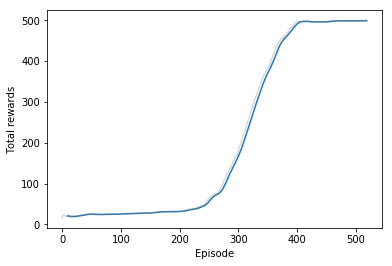

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

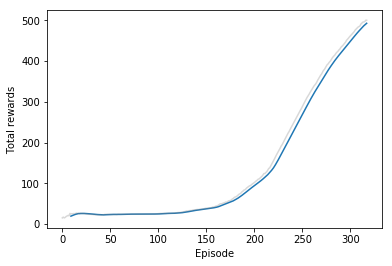

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

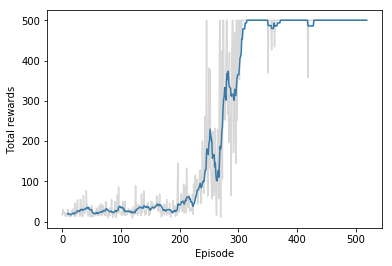

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

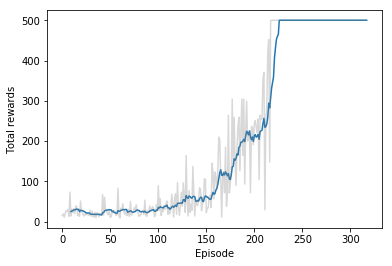

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

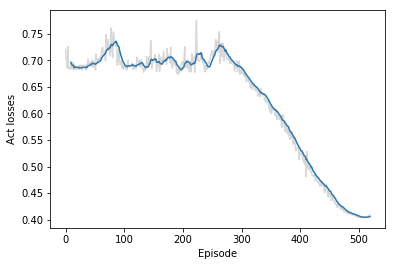

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

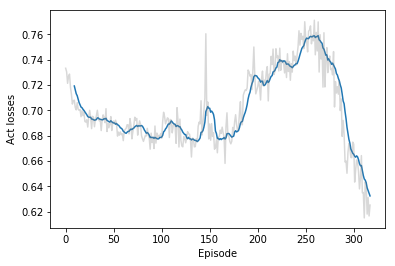

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

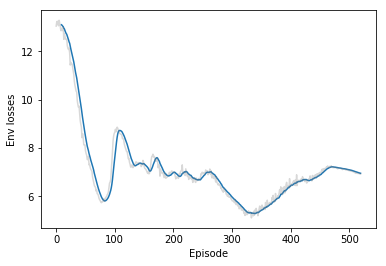

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

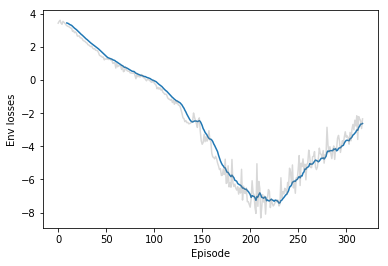

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

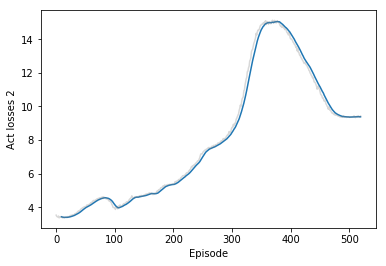

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

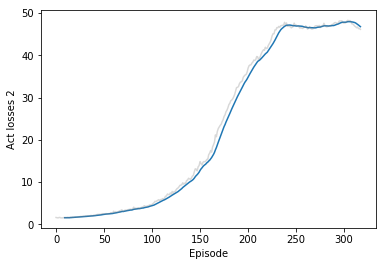

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
